In [7]:
# ADVANCED MUSIC RECOMMENDATION SYSTEM
# Goal: Predict user's likelihood of replaying a song within 30 days
# Dataset: spotify_history.csv (real user streaming behavior)
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Load Dataset
data = pd.read_csv("spotify_history.csv")
data['ts'] = pd.to_datetime(data['ts'])
data = data.sort_values(by=['spotify_track_uri', 'ts'])
data['song_id'] = data['spotify_track_uri']
data['user_id'] = 1  # assuming single user

In [11]:
#Label Repeat Plays (Target = 1 if played again within 30 days)
data['prev_play'] = data.groupby('song_id')['ts'].shift(1)
data['days_since_last_play'] = (data['ts'] - data['prev_play']).dt.days
data['replayed_within_30'] = data['days_since_last_play'].apply(lambda x: 1 if pd.notna(x) and x <= 30 else 0)
data = data[pd.notna(data['days_since_last_play'])]

In [13]:
# STEP 3: Feature Engineering
data['hour'] = data['ts'].dt.hour
data['dayofweek'] = data['ts'].dt.dayofweek
data['play_duration_minutes'] = data['ms_played'] / (1000 * 60)
data['shuffle'] = data['shuffle'].astype(int)
data['skipped'] = data['skipped'].astype(int)

In [15]:
features = ['hour', 'dayofweek', 'play_duration_minutes', 'days_since_last_play', 'shuffle', 'skipped']
target = 'replayed_within_30'
X = data[features]
y = data[target]

In [19]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#Train Model
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [23]:
#Evaluation
y_pred = model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11407
           1       1.00      1.00      1.00     15260

    accuracy                           1.00     26667
   macro avg       1.00      1.00      1.00     26667
weighted avg       1.00      1.00      1.00     26667

Accuracy: 1.0


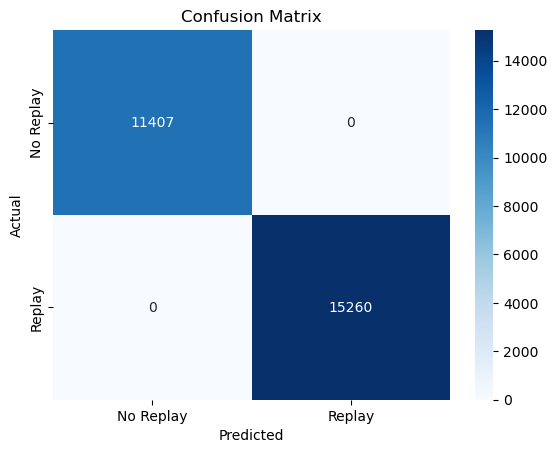

In [25]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Replay','Replay'], yticklabels=['No Replay','Replay'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [27]:
#Recommend Songs

def recommend_replayed_songs(df, model, features):
    latest_plays = df.sort_values('ts').drop_duplicates('song_id', keep='last')
    X_latest = latest_plays[features]
    latest_plays['predicted_replay'] = model.predict(X_latest)
    return latest_plays[latest_plays['predicted_replay'] == 1][['track_name', 'artist_name', 'album_name']]

recommendations = recommend_replayed_songs(data, model, features)


In [29]:
print("\n🎵 Top Recommended Songs (Likely to be Replayed):")
print(recommendations.head(10))


🎵 Top Recommended Songs (Likely to be Replayed):
                                            track_name  \
63                                          I Want You   
89                                          Impossible   
90                                    Do I Wanna Know?   
91          I Still Haven't Found What I'm Looking For   
92                                      Breath Of Life   
94                                          Next To Me   
112                                         Paper Doll   
113                                      Beautiful Day   
184                                              Smile   
258  Purple Haze - Live 10/11/68 Winterland, San Fr...   

                artist_name              album_name  
63                The Kooks  Inside In / Inside Out  
89             James Arthur              Impossible  
90           Arctic Monkeys        Do I Wanna Know?  
91                       U2            U218 Singles  
92   Florence + The Machine          Brea